# Testing Kinetics Models

In [1]:
import tellurium as te
import matplotlib.pyplot as plt
import numpy as np
from scipy import fftpack

In [2]:
# Constants


## Motivation
Consider a linear pathway consisting of three species ``S1``, ``S2``, and ``S3``. That is, ``S1`` $\rightarrow$ ``S2`` $\rightarrow$ ``S3``.

We initialize ``S1`` to 10. We expect that the following outcomes (designated by **On**):

- **O1**: ``S1`` decreases monotonically from 10 to 0.
- **O2**: ``S2`` increases initially, peaks, and then declises to 0.
- **O3**: ``S3`` increases monotonically to 10. 

Here is a first implementation of the model.

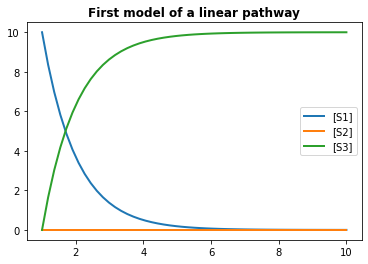

In [3]:
FIRST_IMPLEMENTATION = '''
R1: S1 -> S2; k1*S1  
R2: S2 -> S3; k2*S1

S1 = 10
k1 = 1; k2 = 1
'''
rr = te.loada(FIRST_IMPLEMENTATION)
data = rr.simulate(1, 10)
rr.plot(data, title="First model of a linear pathway")

We see that O1 and O3 are satisfied. However, O2 is not. Why?

Looking carefully at the Antimony model, we see there is an error in the specification of the kinetics law for reaction ``R2``. The kinetics law incorrectly references ``S1`` instead of ``S2``. Below is the corrected model.

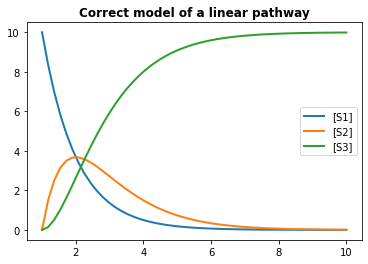

In [4]:
CORRECT_MODEL = '''
R1:  S1 -> S2; k1*S1  
R2a: S2 -> S3; k2*S2

S1 = 10
k1 = 1; k2 = 1;
'''
rr = te.loada(CORRECT_MODEL)
data = rr.simulate(1, 10)
rr.plot(data, title="Correct model of a linear pathway")

In this model, all three outcomes are satisfied.

Although the example is simple, it demonstrates how easy it is to make mistakes in the construction of models, especially complex models. A few mistakes can be detected by tellurium, such as misspelling the name of a floating species. However, the mistake made in the first model, substituting ``S1`` for ``S2``, is not detected by Tellurium.

How do we detect errors in the implementation of models (a processing often referred to as *verification*)? By implementation of the model, we mean that there is a clear understanding of the expected behavior of the model. Verification is about providing ways to detect if the implemention provides the expected behavior.

Although our focus here is on verification, making sure that the intended model is what was built, there is another challenge in modeling. That is, choosing the corrrect model to implement.
Modellers address this by checking for correspondence between simulation data and laboratory measurements.
This process is called **validation**.
Both verification and validation are essential to producing useful models.
However, it makes no sense to validate a model that is implemented incorrectly.
Further, while there is considerable focus in the literature on model validation, there is almost no discussion of verification.

This chaper is about verifying simulation models, or verification testing.
Such testing is done by examining models and their outputs.
There are two kinds of verification tests.

The first kind of verification tests only examines the model itself; the model is not executed.
We refer to these as **static tests**.
For example, one static test is to look for suspicious kinetics laws, such as the kinetics law for ``R2``
that references a floating species that is neither a reactant nor a product (which would be incorrect
if the intended kinetics are mass action).
In the above example, 
Drawing on the experience of the software industry over the last 50 years,
we identify two kinds of validation.

The second kind of verification tests runs simulations and compares the results with what the model developer
expected.
This is illustrated by outcomes O1-O3 and our analysis of the above two simulation models.

The remainder of this chaper discusses static tests, dynamic tests, and provides a detailed example from BioModels.

## Static Testing

1. Relationship between static testing and software linters
1. Reactions have two parts, a **mass trasfer** expression and a **kinetics law**.
2. Errors in mass transfer
   1. Mass balance
   1. Blocked reactions
   1. Unreachable reactions
3. Errors in kinetics laws
   1. Incorrect reference to a chemical species
   1. negative valued 0th order kinetics

## Dynamic Testing

1. Relationship with unit tests. Looking for errors; not proving correctness.
1. Requirements for dynamic tests
   1. Predicates that describe expected behavior.
   1. Check the correspondence

Example 1: Linear pathway
1. Expanding the list of predicates
1. Code that automates testing the result

Example 2
1. Branched pathway
1. Develop the predicates
1. Code that tests for match

## Application to Glycolytic Oscillations

In [5]:
# Constants used in the section
WOLF_MODEL = "../common/models/Jana_WolfGlycolysis.antimony"
MOLECULES = ["Glucose", "fructose_1_6_bisphosphate", "glyceraldehyde_3_phosphate", "glycerate_3_phosphate",
            "pyruvate", "Acetyladehyde", "External_acetaldehyde", "ATP", "ADP", "NAD", "NADH"]
ENDTIME = 5
NUMPOINT = 100*ENDTIME

In this section, we consider tests to verify the simulation of glycolytic oscillations used in our running example. The use case considered is one in which a team plans to modify the original model.
This may involve both the addition and removal of reactions.

Recall that the reactions in this model are:

  ``
  J0: $External_glucose => Glucose; J0_inputFlux;
  J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP; J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n));
  J2: fructose_1_6_bisphosphate => glyceraldehyde_3_phosphate + glyceraldehyde_3_phosphate; J2_k*fructose_1_6_bisphosphate;
  J3: glyceraldehyde_3_phosphate + NADH => NAD + $Glycerol; J3_k*glyceraldehyde_3_phosphate*NADH;
  J4: glyceraldehyde_3_phosphate + ADP + NAD => ATP + glycerate_3_phosphate + NADH; (J4_kg*J4_kp*glyceraldehyde_3_phosphate*NAD*ADP - J4_ka*J4_kk*glycerate_3_phosphate*ATP*NADH)/(J4_ka*NADH + J4_kp*ADP);
  J5: glycerate_3_phosphate + ADP => ATP + pyruvate; J5_k*glycerate_3_phosphate*ADP;
  J6: pyruvate => Acetyladehyde; J6_k*pyruvate;
  J7: Acetyladehyde + NADH => NAD + $ethanol; J7_k*Acetyladehyde*NADH;
  J8: Acetyladehyde => External_acetaldehyde; J8_k1*Acetyladehyde - J8_k2*External_acetaldehyde;
  J9: ATP => ADP; J9_k*ATP;
  J10: External_acetaldehyde => $Sink; J10_k*External_acetaldehyde;``

Below we plot the floating species concentrations.

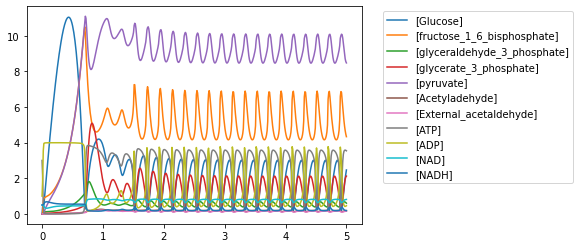

In [6]:
# Floating species concentrations over time
ROADRUNNER = te.loada(WOLF_MODEL)
DATA = ROADRUNNER.simulate(0, ENDTIME, NUMPOINT)
def timePlots(data=DATA):
    p = plt.plot(data[:,0], data[:,1:])
    _ = plt.legend(p, data.colnames[1:], bbox_to_anchor=(1.05, 1), loc='upper left')
timePlots()

We see that there is an initial transient. But starting at time 1.5 sec to 2 sec, concentrations oscillate. We'll focus on these oscillations in our tests of the model.

To do this, we need a way to characterize the oscillation frequencies. A good way to do this is by using the fourier transform.

In [7]:
# Remove reactions
def removeReactions(reactionIds):
    rr = te.loada(WOLF_MODEL)
    for reactionId in reactionIds:
        rr.removeReaction(reactionId, True)
    return rr

# Update parameter values
def updateParameters(parameterDct):
    rr = te.loada(WOLF_MODEL)
    for name, value in parameterDct.items():
        rr[name] = value
    return rr

In [8]:
 # Codes to obtain the amplitude of the fourier transform and their corresponding frequencies.
def getFft(molecule, data=DATA, offset=100, noZeroFreq=True):
    # Returns frequencies, abs(fft) for species
    col = "[%s]" % molecule
    values = data[col]
    numPoint = len(data)
    count = numPoint - offset
    endTime = data["time"][-1]
    freqs = fftpack.fftfreq(count, endTime/numPoint)
    fftValues = np.abs(fftpack.fft(values[offset:]))
    if noZeroFreq:
        freqs = freqs[1:]
        fftValues = fftValues[1:]
    return freqs, fftValues
  
# Codes for plotting the amplitude of a fourier transform
def plotFft(molecule, data=DATA, ax=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots(1,1)
    freqs, fftValues = getFft(molecule, data=data, **kwargs)
    ax.plot(freqs, fftValues)
    ax.set_title(molecule)
    ax.set_ylim([0, 130])

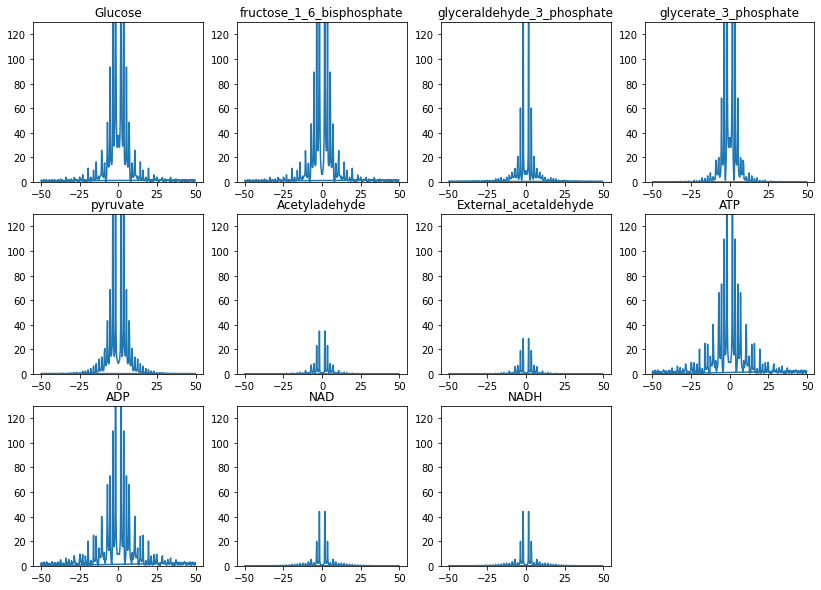

In [9]:
# Construct a plot of the amplitude of the fourier transforms of all floating species.
rr = updateParameters({"J1_k1": 50})
data = rr.simulate(0, ENDTIME, NUMPOINT)
#timePlots(data=data)
numCol = 4
numRow = 3
fig = plt.figure(figsize=(14,10))
for irow in range(numRow):
    for icol in range(numCol):
        idx = irow*numCol + icol
        if idx >= len(MOLECULES):
            break
        ax = plt.subplot2grid((numRow, numCol), (irow, icol), fig=fig)
        #ax = axes[irow, icol]
        plotFft(MOLECULES[idx], data=data, ax=ax)

The above plots use the same scale for the vertical axis ($y$). It seems that all chemical species indicate strong perodicities at a frequency of 5 Hz (5 cycles per second), with harmonics at multiples of this frequency. That said, the magnitude of this periodicity is stronger in some species (e.g., Glucose) than others (e.g., NAD).

Given this, a natural test for the baseline model is that all chemical species show a 5 Hz perodicity. We can check for this using the following codes.

In [10]:
def expectFrequency(molecule, data=DATA, frequency=5.0, topN=2):
    # Return True if the expected frequency is among the topN frequencies with the largest amplitudes
    freqs, amplitudes = getFft(molecule, data=data)
    # Find the indices of the largest amplitudes
    sortedIndices = sorted(range(len(freqs)), key=lambda i: amplitudes[i], reverse=True)
    # See if the frequency is in the frequencies
    return frequency in list(freqs[sortedIndices[:topN]])

This function caculates the FFT for a chemical species (molecule) and then checks if that frequency is in the top amplitudes. Below
are some examples.

In [11]:
molecule = MOLECULES[0]
for frequency, topN in [(5.0, 2), (10.0, 10), (6, 20)]:
    print("%s has a frequency of %f in the top %d amplitudes? %s" 
          % (molecule, frequency, topN, str(expectFrequency(molecule, frequency=frequency, topN=topN))))

Glucose has a frequency of 5.000000 in the top 2 amplitudes? True
Glucose has a frequency of 10.000000 in the top 10 amplitudes? True
Glucose has a frequency of 6.000000 in the top 20 amplitudes? False


Now we show how to create a test that can be run on a roadrunner model. We do this making use of the python unittest infrastructure.
The setUp creates the roadrunner instance for the antimony model being tested.
There are two tests for each chemical species. One test checks that there is a frequency of 5 Hz; the second checks
that there is no frequency of 7 Hz.

In our use case, we consider the model evolving by removing reactions, maybe to make it simpler.
As such, we introduce the variable ``REMOVE_REACTIONS`` that lists the reaction IDs of reactions to remove.
Initially, the list is empty.

In [12]:
import unittest

# Define a class in which the tests will run
class TestModel(unittest.TestCase):
    
    def setUp(self):
        self.roadrunner = te.loada(WOLF_MODEL)
        #for reactionId in REMOVE_REACTIONS:
        #    self.roadrunner.removeReaction(reactionId, True)
        self.roadrunner = updateParameters(PARAMETER_DCT)
        self.roadrunner.reset()
        self.data = self.roadrunner.simulate(0, ENDTIME, NUMPOINT)
        #print(self.roadrunner.getAntimony())
        
    def testGlucoseHasFrequency(self):
        self.assertTrue(expectFrequency("Glucose", data=self.data, frequency=5.0))    
            
    def testGlucoseDoesNotHaveFrequency(self):
        self.assertFalse(expectFrequency("Glucose", data=self.data, frequency=7.0))   
            
    def testNADHHasFrequency(self):
        self.assertTrue(expectFrequency("NADH", data=self.data, frequency=5.0))    
            
    def testNADHDoesNotHaveFrequency(self):
        self.assertFalse(expectFrequency("NADH", data=self.data, frequency=7.0))

In [13]:
# Run the tests without removing any reactions
PARAMETER_DCT = {}
suite = unittest.TestLoader().loadTestsFromTestCase(TestModel)
_ = unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.204s

OK


In [15]:
# Remove reaction 3
PARAMETER_DCT = {"J1_k1": 500}
suite = unittest.TestLoader().loadTestsFromTestCase(TestModel)
_ = unittest.TextTestRunner().run(suite)

.F.F
FAIL: testGlucoseHasFrequency (__main__.TestModel)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-12-eaac687cd300>", line 16, in testGlucoseHasFrequency
    self.assertTrue(expectFrequency("Glucose", data=self.data, frequency=5.0))
AssertionError: False is not true

FAIL: testNADHHasFrequency (__main__.TestModel)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-12-eaac687cd300>", line 22, in testNADHHasFrequency
    self.assertTrue(expectFrequency("NADH", data=self.data, frequency=5.0))
AssertionError: False is not true

----------------------------------------------------------------------
Ran 4 tests in 0.194s

FAILED (failures=2)


In [ ]:
# Can extend this to a kind of sensitivity analysis of parameters

### Checking mass balance

### Checking for cyclic behavior